# 인물 모드 문제점 찾기

## Import

In [1]:
import os
import urllib
import cv2
import numpy as np
import pixellib
import inspect
import tensorflow as tf
print(inspect.getfile(pixellib))
print(tf.__version__)
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

c:\Python310\lib\site-packages\pixellib\__init__.py
2.8.0


ImportError: cannot import name 'BatchNormalization' from 'tensorflow.python.keras.layers'

## 인물모드 직접 해 보기

### 사진 준비

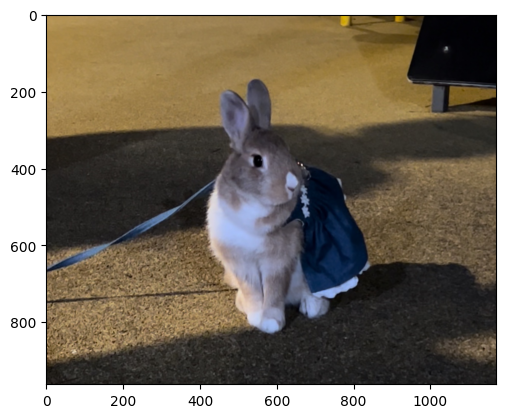

In [2]:
img_path_tony = os.getenv("homepath") + "/Desktop/python/exploration/exploration_12_06/tony.png"
img_tony_o = cv2.imread(img_path_tony)

img_path_my = os.getenv("homepath") + "/Desktop/python/exploration/exploration_12_06/my.png"
img_my_o = cv2.imread(img_path_my)

img_path_snow = os.getenv("homepath") + "/Desktop/python/exploration/exploration_12_06/snow.png"
img_snow_o = cv2.imread(img_path_snow)

plt.imshow(cv2.cvtColor(img_tony_o, cv2.COLOR_BGR2RGB))
plt.show()

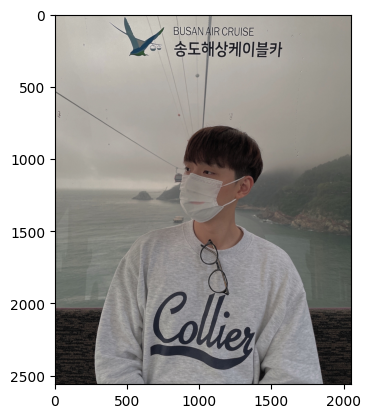

In [3]:
plt.imshow(cv2.cvtColor(img_my_o, cv2.COLOR_BGR2RGB))
plt.show()

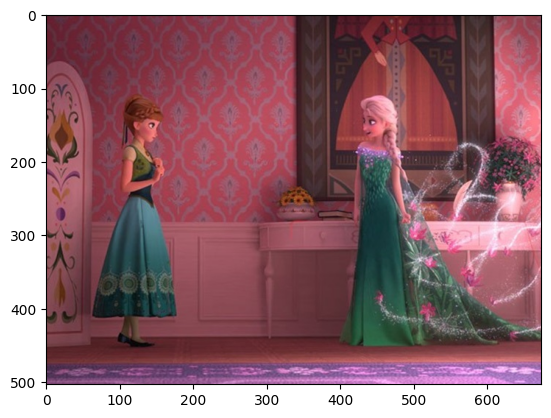

In [4]:
plt.imshow(cv2.cvtColor(img_snow_o, cv2.COLOR_BGR2RGB))
plt.show()

### 모델 다운로드

In [5]:
model_dir = os.getenv("homepath") + "/Desktop/python/exploration/exploration_12_06"
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)

('\\Users\\ASUS/Desktop/python/exploration/exploration_12_06\\deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x2a303fd6890>)

ValueError: You are trying to load a weight file containing 293 layers into a model with 147 layers.  
  
Error에 대한 해결 방법 : python 파일 안에 있는 segmentation 폴더로 들어가 수정이 필요한 .py 파일 접속(파일은 tensolflow 파일안에 있을것이다.)  
이후 tensolflow 의 from import 내용에 대해서 수정 진행.

In [6]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수 호출

In [7]:
segvalues, output = model.segmentAsPascalvoc(img_path_my)
# segmentAsPascalvoc() 입력된 이미지를 분할, 분할출력의 배열을 가져옴

### Pascal Voc 라벨 종류

In [8]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

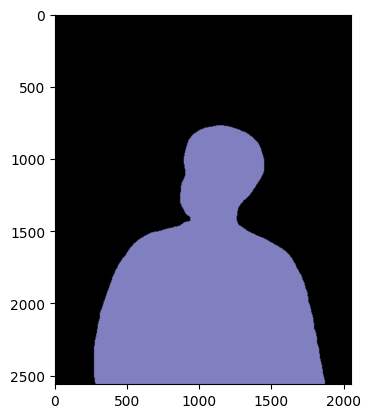

In [9]:
plt.imshow(output)
plt.show()

In [10]:
segvalues

{'class_ids': array([ 0, 15], dtype=int64),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [11]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [12]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [13]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [14]:
seg_color = (128,128,192) # 색상순서 변경

(2560, 2048)


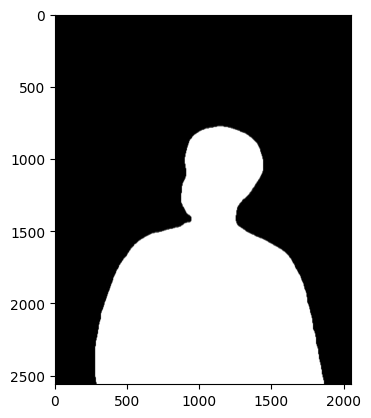

In [15]:
seg_map = np.all(output==seg_color, axis=-1) # output의 픽셀 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
print(seg_map.shape)

plt.imshow(seg_map, cmap='gray')
plt.show()

### 시맨틱 세그멘테이션 해보기

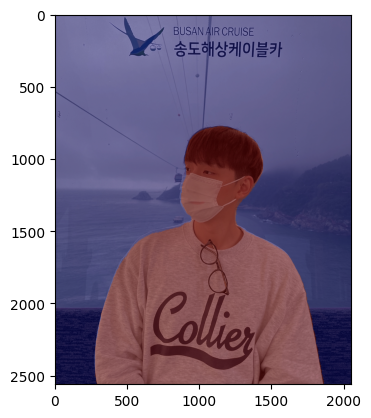

In [16]:
img_my_show = img_my_o.copy() # 원본이미지 파일 img_my_show 파일에 복사
img_mask = seg_map.astype(np.uint8) * 255 # True과 False인 값을 각각 255과 0으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 255와 0을 적당한 색상으로 변경

img_my_show = cv2.addWeighted(img_my_show, 0.6, color_mask, 0.4, 0.0) # 원본 이미지와 마스크를 일정 비율로 합치기(0.6 비율과 0.4비율)

plt.imshow(cv2.cvtColor(img_my_show, cv2.COLOR_BGR2RGB))
plt.show()

### 사진 흐리게 하기

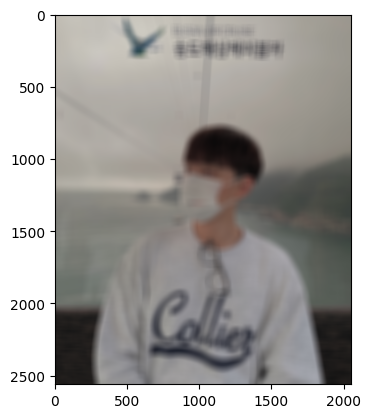

In [17]:
img_my_o_blur = cv2.blur(img_my_o, (60, 60)) # (13,13)은 blurring kernel size
plt.imshow(cv2.cvtColor(img_my_o_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 사진 속 배경만 추출

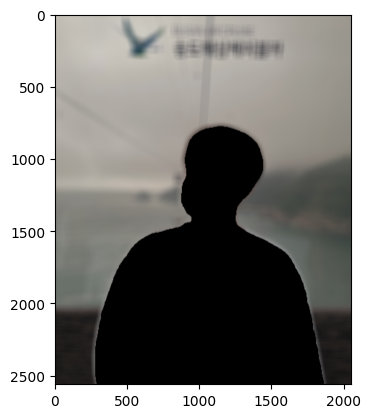

In [18]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # img_mask의 기준이 되는 seg_map 값은 GRAY값으로 지정해놓음
img_bg_mask = cv2.bitwise_not(img_mask_color) # cv2.bitwise_not() : 이미지값 반전, 배경이 0, 사람이 255였으므로 배경이 255, 사람이 0으로 변경
img_bg_blur = cv2.bitwise_and(img_my_o_blur, img_bg_mask) # 블러처리된 배경에서 사람이 0값이었으므로 and에 의해 사람만 빠지고 배경값만 남음
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 합성

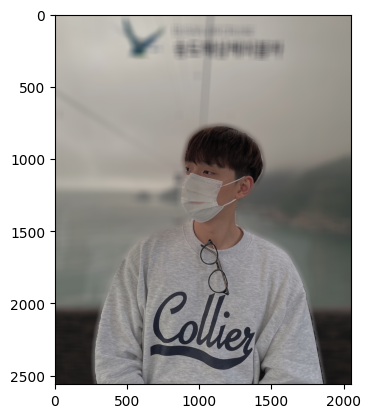

In [19]:
img_concat = np.where(img_mask_color==255, img_my_o, img_bg_blur) 
# img_mask_color의 값이 255(여기선 배경값)일 경우엔 blur 이미지로 출력하며 255가 아닌 값엔 그대로 original 원본사진을 출력
# 그러므로 배경만 흐린 사진이 출력
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

현재로서는 정확하게 아웃포커싱 효과가 적용됐다고 생각하여 다른 사진으로 다시 시도해보는 작업이 필요하다 생각

## 토니 사진으로 진행

In [20]:
segvalues, output = model.segmentAsPascalvoc(img_path_tony)
# segmentAsPascalvoc() 입력된 이미지를 분할, 분할출력의 배열을 가져옴

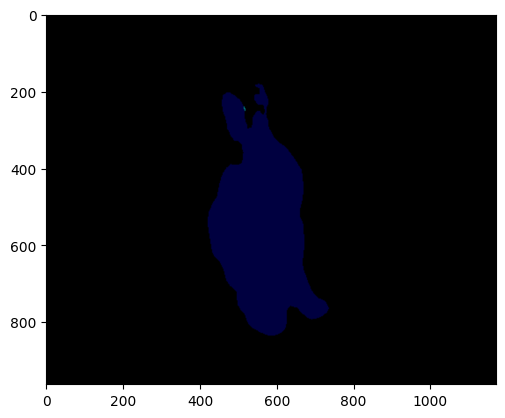

In [21]:
plt.imshow(output)
plt.show()

In [22]:
segvalues

{'class_ids': array([0, 3, 8], dtype=int64),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [23]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bird
cat


#pascalvoc 데이터의 라벨종류  
LABEL_NAMES = [  
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',  
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',  
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'  
]  
  
현재 토니의 사진은 background 와 bird 그리고 cat으로 구분되어 있는것으로 확인

In [24]:
colormap[3] #컬러맵 3에 해당하는 배열 출력

array([128, 128,   0])

In [25]:
colormap[8] #컬러맵 8에 해당하는 배열 출력

array([64,  0,  0])

In [26]:
seg_color = (0, 128, 128) # 색상순서 변경

In [27]:
seg_color2 = (0, 0, 64) # 색상순서 변경2

(962, 1170)


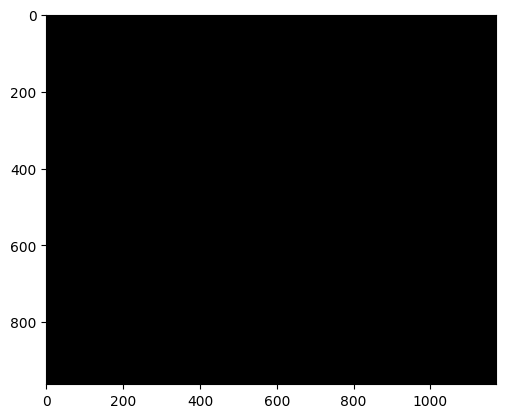

In [28]:
seg_map = np.all(output==seg_color, axis=-1) # output의 픽셀 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
print(seg_map.shape)

plt.imshow(seg_map, cmap='gray')
plt.show()

(962, 1170)


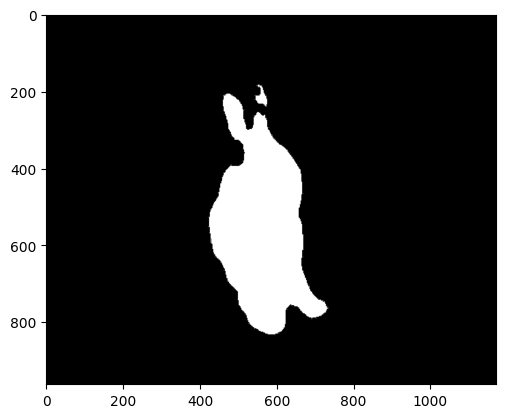

In [29]:
seg_map2 = np.all(output==seg_color2, axis=-1) # output의 픽셀 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
print(seg_map.shape)

plt.imshow(seg_map2, cmap='gray')
plt.show()

bird 로 나왔던 값은 아에 0의 값으로만 나타나고 있기 때문에  
실제 사용하는 값은 cat 값인 seg_map2 값으로 활용

### 시맨틱 세그멘테이션 해보기

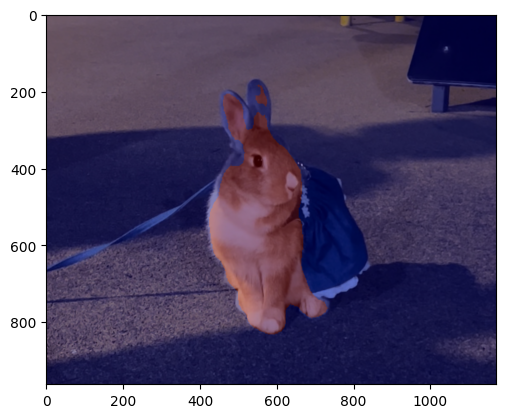

In [30]:
img_tony_show = img_tony_o.copy() # 원본이미지 파일 img_my_show 파일에 복사
img_mask = seg_map2.astype(np.uint8) * 255 # True과 False인 값을 각각 255과 0으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 255와 0을 적당한 색상으로 변경

img_tony_show = cv2.addWeighted(img_tony_show, 0.6, color_mask, 0.4, 0.0) # 원본 이미지와 마스크를 일정 비율로 합치기(0.6 비율과 0.4비율)

plt.imshow(cv2.cvtColor(img_tony_show, cv2.COLOR_BGR2RGB))
plt.show()

### 사진 흐리게 하기

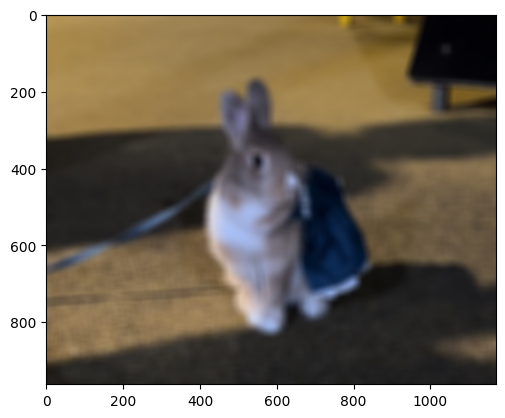

In [31]:
img_tony_o_blur = cv2.blur(img_tony_o, (25, 25)) # (x, y)는 blurring kernel size
plt.imshow(cv2.cvtColor(img_tony_o_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 사진 속 배경만 추출

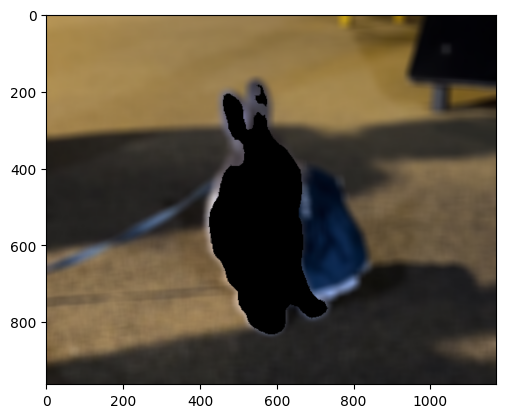

In [32]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # img_mask의 기준이 되는 seg_map 값은 GRAY값으로 지정해놓음
img_bg_mask = cv2.bitwise_not(img_mask_color) # cv2.bitwise_not() : 이미지값 반전, 배경이 0, 사람이 255였으므로 배경이 255, 사람이 0으로 변경
img_bg_blur = cv2.bitwise_and(img_tony_o_blur, img_bg_mask) # 블러처리된 배경에서 사람이 0값이었으므로 and에 의해 사람만 빠지고 배경값만 남음
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐린 배경과 원본 합성

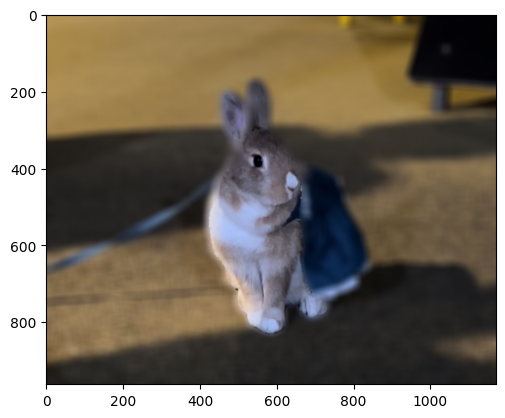

In [33]:
img_concat = np.where(img_mask_color==255, img_tony_o, img_bg_blur) 
# img_mask_color의 값이 255(여기선 배경값)일 경우엔 blur 이미지로 출력하며 255가 아닌 값엔 그대로 original 원본사진을 출력
# 그러므로 배경만 흐린 사진이 출력
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

역시... rabbit 이라는 구체적인 값이 없었다보니 아웃포커싱이 제대로 되지 않은 부분이 있다.  
해당 부분에 대해서는 rabbit 이라는 구체적인 정확도가 없어 세그멘테이션의 한계가 절실히 드러나는 부분이 있는 것 같다.  
  
해당 부분에 대해서는 나융퍼실님의 도움으로 'Yolo' 라는 것을 이용해 직접 데이터셋을 학습시키고 이용하면 된다는 것을 알게 됐지만..  
질문을 너무 늦게 진행하여 이번 프로젝트에선 Yolo를 이용한 데이터셋 학습은 진행하질 못해  
rabbit 에 대한 라벨링은 진행하지 못했다.  
  
그렇다면 애니메이션속의 사람은 어떻게 진행될까?

## 겨울왕국 사진으로 진행

In [34]:
segvalues, output = model.segmentAsPascalvoc(img_path_snow)
# segmentAsPascalvoc() 입력된 이미지를 분할, 분할출력의 배열을 가져옴

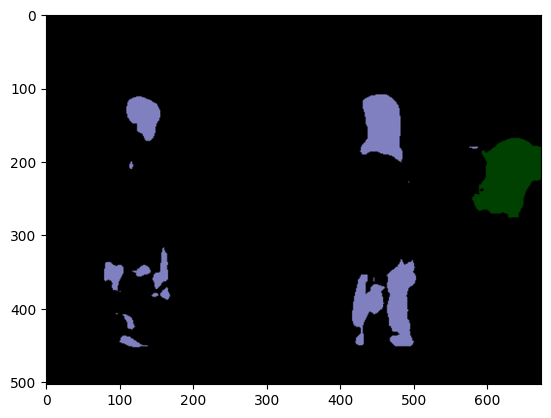

In [35]:
plt.imshow(output)
plt.show()

In [36]:
segvalues

{'class_ids': array([ 0, 15, 16], dtype=int64),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [37]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person
pottedplant


In [38]:
colormap[15] #컬러맵 15에 해당하는 배열 출력

array([192, 128, 128])

In [39]:
seg_color = (128, 128, 192) # 색상순서 변경

(503, 674)


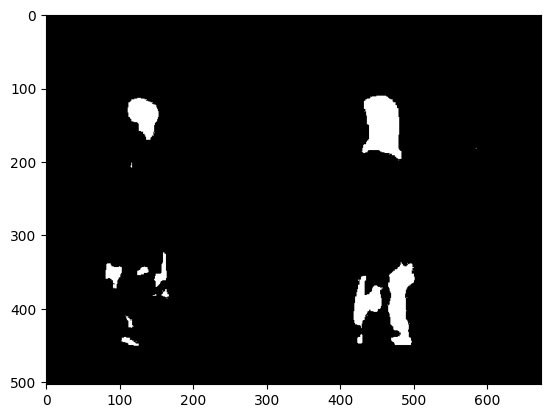

In [40]:
seg_map = np.all(output==seg_color, axis=-1) # output의 픽셀 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
print(seg_map.shape)

plt.imshow(seg_map, cmap='gray')
plt.show()

### 시맨틱 세그멘테이션 해보기

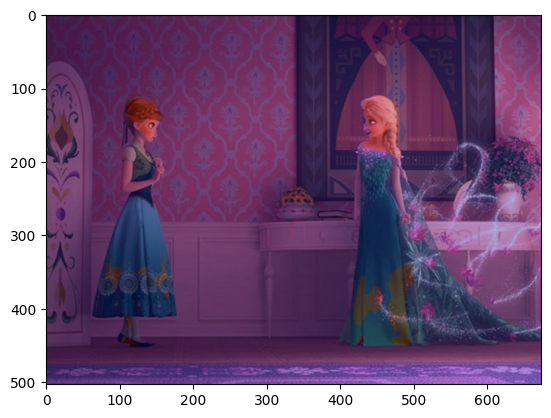

In [41]:
img_snow_show = img_snow_o.copy() # 원본이미지 파일 img_my_show 파일에 복사
img_mask = seg_map.astype(np.uint8) * 255 # True과 False인 값을 각각 255과 0으로 변경
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 255와 0을 적당한 색상으로 변경

img_snow_show = cv2.addWeighted(img_snow_show, 0.7, color_mask, 0.3, 0.0) # 원본 이미지와 마스크를 일정 비율로 합치기(0.6 비율과 0.4비율)

plt.imshow(cv2.cvtColor(img_snow_show, cv2.COLOR_BGR2RGB))
plt.show()

### 사진 흐리게 하기

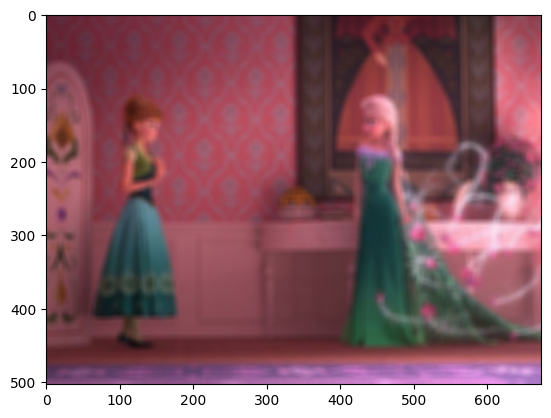

In [42]:
img_snow_o_blur = cv2.blur(img_snow_o, (10, 10)) # (x, y)는 blurring kernel size
plt.imshow(cv2.cvtColor(img_snow_o_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 사진 속 배경만 추출

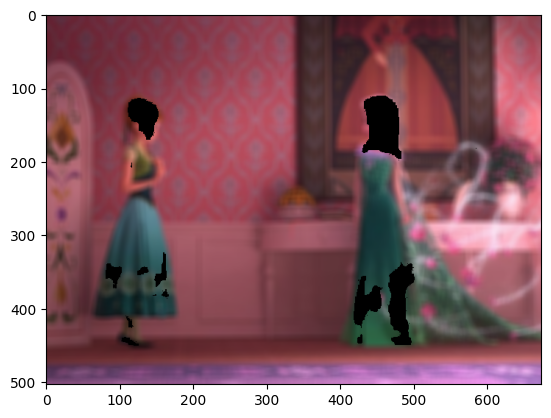

In [43]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) # img_mask의 기준이 되는 seg_map 값은 GRAY값으로 지정해놓음
img_bg_mask = cv2.bitwise_not(img_mask_color) # cv2.bitwise_not() : 이미지값 반전, 배경이 0, 사람이 255였으므로 배경이 255, 사람이 0으로 변경
img_bg_blur = cv2.bitwise_and(img_snow_o_blur, img_bg_mask) # 블러처리된 배경에서 사람이 0값이었으므로 and에 의해 사람만 빠지고 배경값만 남음
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 흐려진 배경과 원본 합성

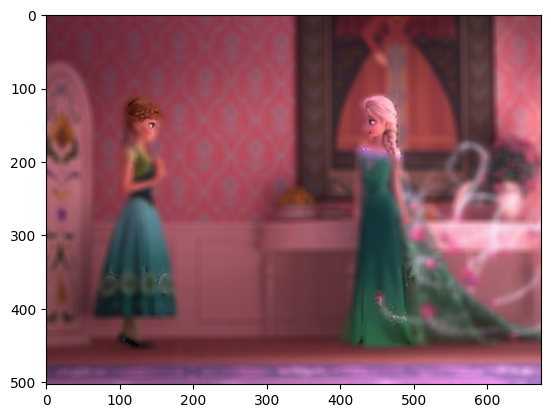

In [44]:
img_concat = np.where(img_mask_color==255, img_snow_o, img_bg_blur) 
# img_mask_color의 값이 255(여기선 배경값)일 경우엔 blur 이미지로 출력하며 255가 아닌 값엔 그대로 original 원본사진을 출력
# 그러므로 배경만 흐린 사진이 출력
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

애니메이션 이미지는... 전혀 갈피를 못잡고 있는 것 같다....  
애니메이션 이미지도 사람의 이미지는 있을텐데.. 왜 못잡을까 그것이 고민이다.  
  
Pascalvoc 의 사람이라는 라벨링은 사람의 이목구비, 그리고 피부색, 질감...? 으로 나뉘는건가..? 싶은  
의문점이 들었지만 이 부분에 대한 내용도 프로젝트 기간내엔 찾아보지 못했으며  
사람이라는 라벨링을 묶는 조건을 찾아보거나 위 사진도 동일하게 Yolo를 이용하여 데이터셋을 훈련  
그 이후 라벨링을 진행하여 segmentation을 진행해보는 것은 따로 진행해봐야 할 문제 같다.

## 회고

이번 프로젝트에선 pascal voc의 Label을 이용해서 사진속에 각각 key 값으로 확인되는 부분에 index 를 부여, 색상코드를 확인 진행  
그리고 segmentation 을 진행하여 사진속에서 라벨별로 나누는 작업을 진행함과 동시에 배경만을 blur 처리한 아웃포커싱도 진행해봤습니다.  
  
꽤 재밌다고 느꼈었던 프로젝트였지만 많이 아쉬웠던 내용은 pascal voc의 Label 안에 원하는 값의 Label 은 없었으며  
추가적으로 다른 데이터셋이 있을까 싶어 찾아봤지만 찾지 못하여 퍼실님의 도움으로 Yolo 라는 것을 알게 되어 데이터셋을 직접 추가하는 방법에 대해서도 찾아보게 되었던 것 같습니다.  
물론 새로운 사실을 알게된 것은 나름 성과가 있었던 내용이라 생각이 들지만, 그래도 결과만을 놓고 봤을 땐 시간이 부족하여  
위와같이 토끼 사진이나 애니메이션 사진에 대해서는 라벨링을 하질 못하여 segmentation, 아웃포커싱 둘다 실패하는 결과물만을 출력하게 되어 아쉬운 결과물인 것 같습니다.  
  
해당 부분에 대해서는 따로 개인공부를 해야함을 느꼈으며 Yolo 라는 것을 이용하여 토끼에 대한 내용은 정확하게 segmentation 진행 후 따로 mask 처리로 지정  
그리고? 해변의 바닷가 사진을 가져와 토끼 사진과의 사이즈를 resize 진행하여 사이즈를 맞춘 뒤 직접적으로 가지 못하는  
바닷가의 모래사장에서도 토끼 사진이 있을 수 있게 해보는 것을 목표로 개인공부를 진행해보려 하며  
이런 마음가짐..? 을 가지게 된것으로 이번 프로젝트는 아쉽지만 얻은게 있다는 자기 위로를 가지며 아쉬운 출력물과 함께 프로젝트 제출을 진행해봅니다.

## Reference

[ImportError: 'tensorflow.python.keras.layers'에서 'BatchNormalization' 이름을 가져올 수 없습니다.](https://stackoverflow.com/questions/70996574/importerror-cannot-import-name-batchnormalization-from-tensorflow-python-ker)  
  

Aiffel 노드 9.인물사진을 만들어 보자  
오순정님 자료